# 0. Links

1. https://www.irs.gov/statistics/soi-tax-stats-annual-extract-of-tax-exempt-organization-financial-data

1a. https://www.irs.gov/pub/irs-tege/2022schedulejform990annotated.pdf

1b. https://www.irs.gov/pub/irs-tege/2022form990withfieldnames.pdf


2. https://data.cms.gov/provider-data/archived-data/hospitals

2a. https://data.cms.gov/provider-data/topics/hospitals



# 1. Imports / helper functions / paths

In [112]:
import numpy as np
import xml.etree.ElementTree as ET
import zipfile
import requests
import os
from tqdm import tqdm
import pandas as pd
from typing import List, Dict, Optional
import re
from concurrent.futures import ProcessPoolExecutor, as_completed
from xml.etree.ElementTree import iterparse
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy import stats

FORM_990_EXTRACT_PATH = "./data/form_990/"
FORM_990_ZIP_PATH = "./load/form_990/"
FORM_990_PROCESSED_PATH = "./processed/form_990/"
CMS_URL = 'https://data.cms.gov/provider-data/sites/default/files/archive/Hospitals/2022/hospitals_10_2022.zip'
CMS_ZIP_PATH = "./data/hospitals/hospital_dataset_api.zip"
CMS_EXTRACT_PATH = "data/hospitals/hospital_dataset"

COM_INSIGHT_URL = 'https://www.communitybenefitinsight.org/api/get_hospitals.php'

COST_REPORT_PATH = './data/cost_report/'

TAX_YEAR = 2020
MIN_HOSPITAL_REV = 250_000_000
MAX_HOSPITAL_REV = 500_000_000

IRS_NS = {"irs": "http://www.irs.gov/efile"}
def download(url, filename, chunk_size=8192):
    response = requests.get(url, stream=True)
    total = int(response.headers.get("content-length", 0))
    with open(filename, "wb") as f, tqdm(total=total, unit_scale=True, unit_divisor=chunk_size) as bar:
        for data in response.iter_content(chunk_size=chunk_size):
            size = f.write(data)
            bar.update(size)


def _text_to_int(x: Optional[str]) -> int:
    """Convert numeric text to int; treat None/'' as 0."""
    if not x:
        return 0
    return int(re.sub(r"[^\d\-]", "", x))

    
def list_xml_files(dir_path: str):
    # Faster than os.listdir + joins; also filter *_public.xml
    with os.scandir(dir_path) as it:
        for e in it:
            if e.is_file() and e.name.endswith("_public.xml"):
                yield e.path

# 2. Data Ingestion

## 2.1 Form 9900 extraction (link 1)

In [2]:

base_url = "https://apps.irs.gov/pub/epostcard/990/xml"
bulk_urls = []

bulk_urls.append(os.path.join(base_url, "2022", "2022_TEOS_XML_01A.zip"))

# uncomment to download additional years
# WARNING: This will take 10s of GB

for i in range(1, 13):
    if i < 10:
        idx_name = f"0{i}"
    else:
        idx_name = str(i)
    bulk_urls.append(os.path.join(base_url, "2023", f"2023_TEOS_XML_{idx_name}A.zip"))
    # bulk_urls.append(os.path.join(base_url, "2024", f"2024_TEOS_XML_{idx_name}A.zip"))
#     # if i <= 7:
#         # bulk_urls.append(os.path.join(base_url, "2025", f"2025_TEOS_XML_{idx_name}A.zip"))

def download_990s(bulk_urls, zip_path, extract_path):
    
    for url in bulk_urls:
        try:
            year = url.split('/')[7]
            index = url.split('/')[8].split('_')[3][:2]
            download_path = os.path.join(zip_path, year)
            save_path = os.path.join(extract_path, year)
            if not os.path.exists(download_path):
                os.mkdir(download_path)
            if not os.path.exists(save_path):
                os.mkdir(save_path)
        
            download_path = os.path.join(download_path, f"{index}.zip")
            save_path = os.path.join(save_path, f"{index}")
        
            if not os.path.exists(save_path):
                print(f"downloading {url}")
                download(url, download_path)
            
                print("extracting...")
                with zipfile.ZipFile(download_path, 'r') as z:
                    for member in tqdm(z.namelist()):
                        z.extract(member, save_path)

            else:
                print(f"{url} already saved at {save_path}. Skipping...")
                        
        except Exception as e:
            print(f"ERROR: {e}; url = {url}")

download_990s(bulk_urls, FORM_990_ZIP_PATH, FORM_990_EXTRACT_PATH)

downloading https://apps.irs.gov/pub/epostcard/990/xml/2022/2022_TEOS_XML_01A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 38.8M/38.8M [00:37<00:00, 68.8Mit/s]


extracting...


100%|██████████████████████████████████████████████████████████████████████████████████████| 433529/433529 [04:36<00:00, 1566.35it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_01A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1.83M/1.83M [00:04<00:00, 28.1Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 21513/21513 [00:25<00:00, 833.22it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_02A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3.50M/3.50M [00:09<00:00, 25.6Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 40304/40304 [00:49<00:00, 810.43it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_03A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2.94M/2.94M [00:05<00:00, 35.3Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 36224/36224 [00:39<00:00, 922.46it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_04A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3.64M/3.64M [00:09<00:00, 26.9Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 42995/42995 [00:57<00:00, 753.68it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_05A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 14.8M/14.8M [00:41<00:00, 24.1Mit/s]


extracting...


100%|███████████████████████████████████████████████████████████████████████████████████████| 156228/156228 [04:00<00:00, 648.68it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_06A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2.44M/2.44M [00:06<00:00, 24.9Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 29240/29240 [00:36<00:00, 797.62it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_07A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3.28M/3.28M [00:06<00:00, 32.3Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 38027/38027 [00:50<00:00, 756.44it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_08A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3.97M/3.97M [00:09<00:00, 29.1Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 42301/42301 [01:04<00:00, 659.46it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_09A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2.99M/2.99M [00:11<00:00, 18.1Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 35070/35070 [00:56<00:00, 623.97it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_10A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 4.95M/4.95M [00:18<00:00, 18.0Mit/s]


extracting...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 56858/56858 [01:32<00:00, 614.44it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_11A.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████| 17.9M/17.9M [01:00<00:00, 19.8Mit/s]


extracting...


100%|███████████████████████████████████████████████████████████████████████████████████████| 186387/186387 [08:40<00:00, 358.22it/s]


downloading https://apps.irs.gov/pub/epostcard/990/xml/2023/2023_TEOS_XML_12A.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.80M/1.80M [00:11<00:00, 10.3Mit/s]


extracting...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20007/20007 [00:54<00:00, 369.16it/s]


## 2.2 CMS data (link 2)

In [3]:

def get_cms_data(cms_url, 
                 zip_path, 
                 extract_path, 
                 force = False):
    if not os.path.exists(zip_path) or force:
        print(f"downloading {cms_url} to {zip_path}...")
        download(
            cms_url,
            zip_path
        )
    else:
        print(f"{zip_path} already exists. Skipping download")

    if not os.path.exists(extract_path) or force:
        print(f"unzipping {zip_path} to {extract_path}...")
        with zipfile.ZipFile(zip_path, "r") as z:
            for member in tqdm(z.namelist()):
                z.extract(member, extract_path)

    else:
        print(f"{extract_path} already exists. Skipping Extraction")

    folders = os.listdir(extract_path)
    assert len(folders) == 1
    
    return os.path.join(extract_path, folders[0])



cms_root_path = get_cms_data(CMS_URL, CMS_ZIP_PATH, CMS_EXTRACT_PATH)

downloading https://data.cms.gov/provider-data/sites/default/files/archive/Hospitals/2022/hospitals_10_2022.zip to hospital_dataset_api.zip...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 0.22M/0.22M [00:00<00:00, 45.9Mit/s]

hospital_dataset_api already exists. Skipping Extraction


## 2.3 Bridge file

In [61]:
def get_bridge_file():
    if os.path.exists("bridge.csv"):
        return pd.read_csv("bridge.csv")
        
    download(
        'https://www.communitybenefitinsight.org/api/get_hospitals.php',
        'test.json'
    )
    
    with open('test.json', 'r') as f:
        data = json.load(f)
    
    bridge = pd.DataFrame(data)
    bridge.to_csv("bridge.csv")
    return bridge
    
bridge = get_bridge_file()

## 2.4 Cost Report

In [75]:
def download_cost_report(cost_report_path, force = False):
    if not os.path.exists(cost_report_path):
        os.makedirs(cost_report_path)

    chunk_size = 1000
    offset = 0
    num_records = chunk_size
    index = 0
    max_iter = 100
    while num_records == chunk_size:
        chunk_path = f'{cost_report_path}/{index}.json'

        if not os.path.exists(chunk_path) or force:
            download(
                f'https://data.cms.gov/data-api/v1/dataset/44060663-47d8-4ced-a115-b53b4c270acb/data?size={chunk_size}&offset={offset}',
                chunk_path
            )

        with open(chunk_path, 'r') as f:
            data = json.load(f)

        df = pd.DataFrame(data)
        df.to_csv(f'{cost_report_path}/{index}.csv')

        num_records = len(df)
        index += 1
        offset += chunk_size

        if index == max_iter:
            raise RuntimeError("max iter reached")

    dfs = []
    for f in os.listdir(cost_report_path):
        if ".csv" in f:
            dfs.append(pd.read_csv(os.path.join(cost_report_path, f)))

    df_proc = pd.concat(dfs)
    df_proc.to_csv(os.path.join(cost_report_path, "cost_report_proc.csv"))
    
download_cost_report(COST_REPORT_PATH)

# 3. Load & Clean datasets

## 3.1 Parse compensation data

In [45]:
# XML paths to search for in 990 data

WANTED = {
    "ReturnHeader/Filer/EIN": "ein",
    "ReturnHeader/Filer/BusinessName/BusinessNameLine1Txt": "name",
    "ReturnHeader/Filer/BusinessName/BusinessNameLine2Txt": "name2",
    "ReturnHeader/TaxYr": "tax_year",
    "ReturnHeader/ReturnTypeCd": "form_type",
    "ReturnHeader/Filer/USAddress/StateAbbreviationCd": "state",
    "ReturnHeader/Filer/USAddress/CityNm": "city",
    "ReturnHeader/IRS990ScheduleHInd": "filed_schedule_h_flag",
    "ReturnData/IRS990/CYTotalRevenueAmt": "revenue",
    "ReturnData/IRS990/CYRevenueLessExpensesAmt": "operating_profit",
    
}

# Convert absolute paths like ReturnHeader/Filer/EIN to tuple('ReturnHeader','Filer','EIN')
WANTED_PATHS = {tuple(k.split('/')): v for k, v in WANTED.items()}


def strip_namespaces(root):
    """Remove namespace URIs from all tags in an ElementTree root."""
    for elem in root.iter():
        if "}" in elem.tag:
            elem.tag = elem.tag.split("}", 1)[1]
    return root
    
def fast_parse_top_level(xml_path: str) -> dict:
    found = {v: None for v in WANTED.values()}
    remaining = set(WANTED_PATHS.keys())
    stack = []

    for event, elem in iterparse(xml_path, events=("start", "end")):
        tag = elem.tag.split("}", 1)[1] if "}" in elem.tag else elem.tag

        if event == "start":
            stack.append(tag)
        else:  # end
            # suffix-match: ... Return › ReturnHeader › Filer › EIN  endswith  ReturnHeader › Filer › EIN
            for wanted_path in list(remaining):
                if len(stack) >= len(wanted_path) and tuple(stack[-len(wanted_path):]) == wanted_path:
                    key = WANTED_PATHS[wanted_path]
                    text = (elem.text or "").strip()
                    found[key] = text if text != "" else None
                    remaining.remove(wanted_path)
            stack.pop()
            elem.clear()
            if not remaining:
                break

    # Normalize types
    rev = found.get("revenue")
    if rev:
        try:
            found["revenue"] = int(rev.replace(",", ""))
        except ValueError:
            found["revenue"] = 0
    else:
        found["revenue"] = 0
    return found


def parse_schedule_j_person_rows(xml_path: str) -> List[Dict]:
    """
    Return a list of dict rows for Schedule J people. Each row contains
    name, title, and all comp components for filing org and related orgs.
    Handles both OfficerTrstKeyEmplGrp and RltdOrgOfficerTrstKeyEmplGrp.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    rows = []

    # Two possible groups in Schedule J:
    groups = []
    groups += root.findall(".//irs:IRS990ScheduleJ/irs:OfficerTrstKeyEmplGrp", IRS_NS)
    groups += root.findall(".//irs:IRS990ScheduleJ/irs:RltdOrgOfficerTrstKeyEmplGrp", IRS_NS)

    for g in groups:
        get = lambda tag: g.find(f"irs:{tag}", IRS_NS)

        row = {
            "PersonNm":           (get("PersonNm").text if get("PersonNm") is not None else None),
            "TitleTxt":           (get("TitleTxt").text if get("TitleTxt") is not None else None),

            # Base
            "BaseComp_Filer":     _text_to_int(get("BaseCompensationFilingOrgAmt").text if get("BaseCompensationFilingOrgAmt") is not None else None),
            "BaseComp_Related":   _text_to_int(get("CompensationBasedOnRltdOrgsAmt").text if get("CompensationBasedOnRltdOrgsAmt") is not None else None),

            # Bonus (covers “bonus & incentive” in IRS parlance)
            "Bonus_Filer":        _text_to_int(get("BonusFilingOrganizationAmount").text if get("BonusFilingOrganizationAmount") is not None else None),
            "Bonus_Related":      _text_to_int(get("BonusRelatedOrganizationsAmt").text if get("BonusRelatedOrganizationsAmt") is not None else None),

            # Other comp
            "Other_Filer":        _text_to_int(get("OtherCompensationFilingOrgAmt").text if get("OtherCompensationFilingOrgAmt") is not None else None),
            "Other_Related":      _text_to_int(get("OtherCompensationRltdOrgsAmt").text if get("OtherCompensationRltdOrgsAmt") is not None else None),

            # Deferred
            "Deferred_Filer":     _text_to_int(get("DeferredCompensationFlngOrgAmt").text if get("DeferredCompensationFlngOrgAmt") is not None else None),
            "Deferred_Related":   _text_to_int(get("DeferredCompRltdOrgsAmt").text if get("DeferredCompRltdOrgsAmt") is not None else None),

            # Nontaxable benefits
            "Nontax_Filer":       _text_to_int(get("NontaxableBenefitsFilingOrgAmt").text if get("NontaxableBenefitsFilingOrgAmt") is not None else None),
            "Nontax_Related":     _text_to_int(get("NontaxableBenefitsRltdOrgsAmt").text if get("NontaxableBenefitsRltdOrgsAmt") is not None else None),

            # Totals (preferred if present)
            "TotalComp_Filer":    _text_to_int(get("TotalCompensationFilingOrgAmt").text if get("TotalCompensationFilingOrgAmt") is not None else None),
            "TotalComp_Related":  _text_to_int(get("TotalCompensationRltdOrgsAmt").text if get("TotalCompensationRltdOrgsAmt") is not None else None),
        }

        # Derived fields
        row["Bonus_Total"] = row["Bonus_Filer"] + row["Bonus_Related"]

        # Prefer IRS reported totals; if missing, fall back to summing components
        total_reported = row["TotalComp_Filer"] + row["TotalComp_Related"]
        if total_reported > 0:
            row["TotalComp_AllIn"] = total_reported
        else:
            row["TotalComp_AllIn"] = (
                row["BaseComp_Filer"] + row["BaseComp_Related"] +
                row["Bonus_Filer"] + row["Bonus_Related"] +
                row["Other_Filer"] + row["Other_Related"] +
                row["Deferred_Filer"] + row["Deferred_Related"] +
                row["Nontax_Filer"] + row["Nontax_Related"]
            )

        row["IncentivePct"] = (
            row["Bonus_Total"] / row["TotalComp_AllIn"]
            if row["TotalComp_AllIn"] > 0 else None
        )

        rows.append(row)

    return rows

def parse_xml(path):

    try:
        row = fast_parse_top_level(path)
        comp_data = parse_schedule_j_person_rows(path)
    
        for c in comp_data:
            for r in row:
                c[r] = row[r]
    
        return comp_data

    except Exception as e:
        msg = f"Error: {e}; path = {path}"
        print(msg)
        # with open("log.txt", "a") as f:
        #     f.write(msg)

        return []


def parse_xml_dir(dir_path,
                  save_path,
                  workers=os.cpu_count(),
                  limit = None):

    
    files = list(list_xml_files(dir_path))
    rows = []
    print(f"running parse all with {workers} workers")

    if workers == 1:
        for i, f in enumerate(tqdm(files)):
            data = parse_xml(f)
            if len(data) > 0:
                rows += data
                
            if limit is not None and i >= limit: 
                break
    else:
        with ProcessPoolExecutor(max_workers=workers) as ex:
            futures = {ex.submit(parse_xml, f): f for f in files}
            for fut in tqdm(as_completed(futures), total=len(files)):
                rows += fut.result()
    df = pd.DataFrame(rows)
    df.to_csv(save_path, index=False)
    return df    

def parse_all_dirs(src_dir, dest_dir, wanted):
    if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)

    for year in os.listdir(src_dir):
        for idx in os.listdir(os.path.join(src_dir, year)):
            for folder in os.listdir(os.path.join(src_dir, year, idx)):
                path = os.path.join(src_dir, year, idx, folder)

                save_path = os.path.join(dest_dir, 
                                         f"{year}_{idx}_{folder}_processed.csv")
                msg_id = f"{year} {idx} {folder}"
                if not os.path.exists(save_path):
                    try:
                        parse_xml_dir(dir_path = path, save_path = save_path)
                        msg = f"Successfully parsed {msg_id}"
                        print(msg)
                    except Exception as e:
                        msg = f"ERROR: {e}; {msg_id}"
                        print(msg)
                else:
                    print(f"{save_path} already exists. Skipping...")

def collect_dfs(processed_dir, save_dir):
    fs = os.listdir(processed_dir)
    dfs = []
    for f in fs:
        if ".csv" not in f: 
            continue
        dfs.append(pd.read_csv(os.path.join(processed_dir, f)))

    df = pd.concat(dfs, ignore_index=True)
    df.to_csv(save_dir)

parse_all_dirs(FORM_990_EXTRACT_PATH, FORM_990_PROCESSED_PATH)
collect_dfs(FORM_990_PROCESSED_PATH, "form_990_processed.csv")

./processed/2022_01_2022Redo_cycle01_41_processed.csv already exists. Skipping...
./processed/2023_02_2023_TEOS_XML_02A_processed.csv already exists. Skipping...
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 20007/20007 [00:34<00:00, 574.55it/s]


Successfully parsed 2023 12 2023_TEOS_XML_12A
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 36224/36224 [00:55<00:00, 651.42it/s]


Successfully parsed 2023 03 2023_TEOS_XML_03A
running parse all with 4 workers


100%|███████████████████████████████████████████████████████████████████████████████████████| 156228/156228 [05:23<00:00, 483.13it/s]


Successfully parsed 2023 05 2023_TEOS_XML_05A
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 29240/29240 [00:58<00:00, 495.73it/s]


Successfully parsed 2023 06 2023_TEOS_XML_06A
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 42301/42301 [01:38<00:00, 429.01it/s]


Successfully parsed 2023 08 2023_TEOS_XML_08A
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 35070/35070 [00:58<00:00, 598.46it/s]


Successfully parsed 2023 09 2023_TEOS_XML_09A
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 56858/56858 [01:32<00:00, 612.55it/s]


Successfully parsed 2023 10 2023_TEOS_XML_10A
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 21513/21513 [00:33<00:00, 650.02it/s]


Successfully parsed 2023 01 2023_TEOS_XML_01A
running parse all with 4 workers


100%|███████████████████████████████████████████████████████████████████████████████████████| 186387/186387 [06:14<00:00, 497.07it/s]


Successfully parsed 2023 11 2023_TEOS_XML_11A
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 38027/38027 [01:01<00:00, 622.79it/s]


Successfully parsed 2023 07 2023_TEOS_XML_07A
running parse all with 4 workers


100%|█████████████████████████████████████████████████████████████████████████████████████████| 42995/42995 [01:14<00:00, 574.02it/s]


Successfully parsed 2023 04 2023_TEOS_XML_04A


## 3.2 Roll up form 990 data

In [47]:
def clean_990(df_990, year, min_rev, max_rev):
    df_990 = df_990[df_990['tax_year'] == year]
    df_990 = df_990.groupby([
        'name',
        'ein',
        'tax_year',
        'filed_schedule_h',
        'state',
        'city'
    ]).sum().reset_index()[[
        'name',
        'ein',
        'tax_year',
        'state',
        'city',
        'filed_schedule_h',
        'revenue',
        'TotalComp_AllIn',
        'Bonus_Total'
    ]]

    df_990['incentive_perc'] = df_990.apply(lambda r: r['TotalComp_AllIn'] / r['Bonus_Total'] if r['Bonus_Total'] > 0 else 0, axis = 1)

    df_990 = df_990[(df_990['revenue'] >= min_rev) & (df_990['revenue'] <= max_rev)]
    return df_990

    

# 3.3 Load and pivot CMS data

In [163]:
def get_hcahps(cms_root_path):
    hcahps = pd.read_csv(os.path.join(cms_root_path, 'HCAHPS-Hospital.csv'))
    hcahps = hcahps.pivot_table(
        index = [
            "Facility ID",
            "Facility Name",
            "City",
            "State",
            "ZIP Code"
        ],
        columns = [
            "HCAHPS Question"
        ],
        values = [
            "HCAHPS Answer Percent",
            "Patient Survey Star Rating",
            "HCAHPS Linear Mean Value"
        ],
        aggfunc = "first"
    ).reset_index()
    hcahps.columns = [
        f"{measure}: {val}" if len(measure) > 0 else val
        for val, measure in hcahps.columns
    ]

    hcahps = hcahps.drop(
        columns = [c for c in hcahps.columns if (hcahps[c] == 'Not Applicable').all()]
    )

    hcahps = hcahps.replace('Not Available', np.nan)
    for c in hcahps.columns:
        if ':' in c:
            hcahps[c] = hcahps[c].astype(float)
            
    return hcahps

def get_comp_mort(cms_root_path):
    comp_mort = pd.read_csv(os.path.join(cms_root_path, 'Complications_and_Deaths-Hospital.csv'))
    comp_mort = comp_mort.pivot_table(
        index = [
            "Facility ID",
            "Facility Name",
            "City",
            "State",
            "ZIP Code"
        ],
        columns = [
            "Measure Name"
        ],
        values = [
            "Denominator",
            "Score",
            "Lower Estimate",
            "Higher Estimate"
        ],
        aggfunc = "first"
    ).reset_index()
    comp_mort.columns = [
        f"{measure}: {val}" if len(measure) > 0 else val
        for val, measure in comp_mort.columns
    ]

    comp_mort = comp_mort.drop(
        columns = [c for c in comp_mort.columns if (comp_mort[c] == 'Not Applicable').all() or (comp_mort[c] == 'Not Available').all()]
    )

    comp_mort = comp_mort.replace('Not Available', np.nan)


    for c in comp_mort.columns:
        if ':' in c:
            comp_mort[c] = comp_mort[c].astype(float)
    return comp_mort

def get_hosp_gen_info(cms_root_path):
    hosp_info = pd.read_csv(os.path.join(cms_root_path, "Hospital_General_Information.csv"))
    return hosp_info

def get_hvbp_clinical_outcomes(cms_root_path):
    hvbp_clin_out = pd.read_csv(os.path.join(cms_root_path, "hvbp_clinical_outcomes.csv"))
    return hvbp_clin_out 
    


# 3.4 Cost Report

In [76]:
def get_cost_report(cost_report_path):
    return pd.read_csv(os.path.join(cost_report_path, "cost_report_proc.csv"))

cost_report = get_cost_report(COST_REPORT_PATH)

In [93]:
cost_report['Number of Interns and Residents (FTE)']

0       209.72
1          NaN
2        27.15
3          NaN
4       128.23
         ...  
6059    132.95
6060       NaN
6061      3.71
6062       NaN
6063       NaN
Name: Number of Interns and Residents (FTE), Length: 6064, dtype: float64

# 4 Join datasets

In [209]:
def join_datasets(tax_year,
                  min_hospital_rev,
                  max_hospital_rev,
                  cms_root_path,
                  cost_report_path,
                  columns = None
                 ):
    

    form_990 = pd.read_csv('form_990_processed.csv')
    df_990_cleaned = clean_990(form_990, tax_year, min_hospital_rev, max_hospital_rev)
    hcahps = get_hcahps(cms_root_path)
    comp_mort = get_comp_mort(cms_root_path)
    hosp_info = get_hosp_gen_info(cms_root_path)
    hvbp_clin_out = get_hvbp_clinical_outcomes(cms_root_path)
    bridge = get_bridge_file()

    cost_report = get_cost_report(cost_report_path)
    
    hcahps['hcahps_name'] = hcahps['Facility Name'].str.lower()
    hcahps['Facility ID'] = hcahps['Facility ID'].astype(str)
    hcahps.columns = hcahps.columns.map(lambda x: str(x) + " - HCAHPS")
    
    comp_mort['Facility ID'] = comp_mort['Facility ID'].astype(str)
    comp_mort.columns = comp_mort.columns.map(lambda x: str(x) + " - complications and mortality report")
    
    bridge['bridge_name'] = bridge['name'].str.lower()
    bridge['ein'] = bridge['ein'].astype(str)
    bridge.columns = bridge.columns.map(lambda x: str(x) + " - bridge")
    
    cost_report['Provider CCN'] = cost_report['Provider CCN'].astype(str)
    cost_report['is_teaching_hospital'] = (cost_report['Number of Interns and Residents (FTE)'] > 0).astype(int)
    cost_report.columns = cost_report.columns.map(lambda x: str(x) + " - cost report")
    
    df_990_cleaned['ein'] = df_990_cleaned['ein'].astype(str)
    df_990_cleaned.columns = df_990_cleaned.columns.map(lambda x: str(x) + " - 990")
    
    merged = pd.merge(hcahps,
                      bridge,
                      left_on = 'hcahps_name - HCAHPS',
                      right_on = 'bridge_name - bridge')
    merged = pd.merge(merged,
                      cost_report,
                      left_on = 'Facility ID - HCAHPS',
                      right_on = 'Provider CCN - cost report')
    merged = pd.merge(merged,
                      comp_mort,
                      right_on = 'Facility ID - complications and mortality report',
                      left_on = 'Facility ID - HCAHPS')
    
    merged = pd.merge(merged,
                      df_990_cleaned,
                      left_on='ein - bridge',
                      right_on = 'ein - 990')

    fname = f'merged_dataset_year={TAX_YEAR}_cmsYear=2022_minRev={MIN_HOSPITAL_REV}_maxRev={MAX_HOSPITAL_REV}'
    
    merged.to_csv(f'{fname}_raw.csv')
    
    if columns is not None:
        merged = merged.rename(columns = columns)

    if columns is None:
        merged.to_csv(f'{fname}.csv')
        return merged
    merged = merged[list(columns.values())]
    merged.to_csv(f'{fname}.csv')
    return merged

columns = {
    'Facility ID - HCAHPS': 'Facility ID',
    'Facility Name - HCAHPS': 'Facility Name',
    'ein - 990': "EIN",
    'is_teaching_hospital - cost report': 'is_teaching_hospital',
    'incentive_perc - 990': 'incentive_perc',
    'Number of Beds - cost report': 'Number of Beds',

    'Overall hospital rating - linear mean score: HCAHPS Linear Mean Value - HCAHPS': 'Overall Linear Mean HCAHPS Hospital Rating',
    "Death rate for CABG surgery patients: Score - complications and mortality report": "CABG Death Rate Score",
    "Death rate for COPD patients: Score - complications and mortality report": "COPD Death Rate Score",
    "Death rate for heart attack patients: Score - complications and mortality report": "Heart Attack Death Rate Score",
    "Death rate for heart failure patients: Score - complications and mortality report": "Heart Failure Death Rate Score",
    "Death rate for stroke patients: Score - complications and mortality report": "Stroke Death Rate Score",
    "Rate of complications for hip/knee replacement patients: Score - complications and mortality report": "Rate of Complications of Hip or Knee Replacement Score",
    
    
}
merged = join_datasets(TAX_YEAR, 
                       MIN_HOSPITAL_REV,
                       MAX_HOSPITAL_REV,
                       cms_root_path,
                       COST_REPORT_PATH,
                       columns = None)

/tmp/ipykernel_427/3811464494.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  hcahps = pd.read_csv(os.path.join(cms_root_path, 'HCAHPS-Hospital.csv'))


In [210]:
for i in merged.columns:
    print(i)

Facility ID - HCAHPS
Facility Name - HCAHPS
City - HCAHPS
State - HCAHPS
ZIP Code - HCAHPS
Patients who "Agree" that the staff took my preferences into account when determining my health care needs: HCAHPS Answer Percent - HCAHPS
Patients who "Agree" that they understood the purposes of their medications when leaving the hospital: HCAHPS Answer Percent - HCAHPS
Patients who "Agree" that they understood their responsiblities in managing their health: HCAHPS Answer Percent - HCAHPS
Patients who "Agree" they understood their care when they left the hospital: HCAHPS Answer Percent - HCAHPS
Patients who "Disagree" or "Strongly Disagree" that the staff took my preferences into account when determining my health care needs: HCAHPS Answer Percent - HCAHPS
Patients who "Disagree" or "Strongly Disagree" that they understood the purposes of their medications when leaving the hospital: HCAHPS Answer Percent - HCAHPS
Patients who "Disagree" or "Strongly Disagree" that they understood their responsi


x: incentive_perc
y: Overall Linear Mean HCAHPS Hospital Rating
slope: 0.00967908896898477
intercept: 88.45436029783778
r: 0.1430497320883639
p: 0.36013016444261814
std err: 0.010458415149587126
    

x: incentive_perc
y: CABG Death Rate Score
slope: 0.0926940806740659
intercept: 2.7444664870032436
r: 0.31061366628968756
p: 0.5490636357893128
std err: 0.14183066105284622
    

x: incentive_perc
y: COPD Death Rate Score
slope: 0.006086292969787035
intercept: 8.214484990284834
r: 0.17584984966869674
p: 0.32763653888857835
std err: 0.0061194037809950835
    

x: incentive_perc
y: Heart Attack Death Rate Score
slope: -0.029532372002971968
intercept: 13.053986826475212
r: -0.37888643522526444
p: 0.35464866698770386
std err: 0.029448515355901664
    

x: incentive_perc
y: Heart Failure Death Rate Score
slope: 0.0001459555178401142
intercept: 11.906235841619838
r: 0.06377416403308112
p: 0.6958329955528924
std err: 0.00037050918214264817
    

x: incentive_perc
y: Stroke Death Rate Score
slop

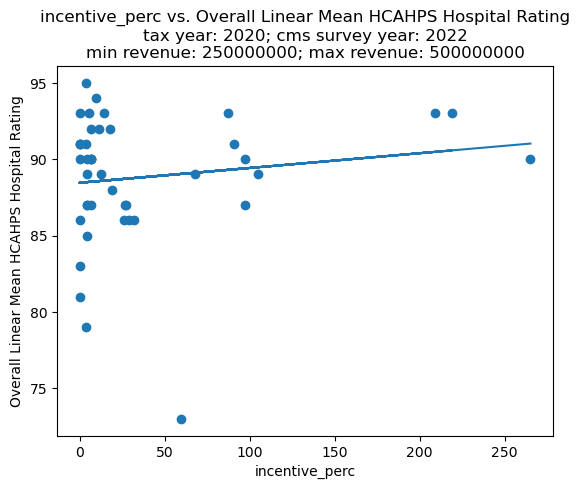

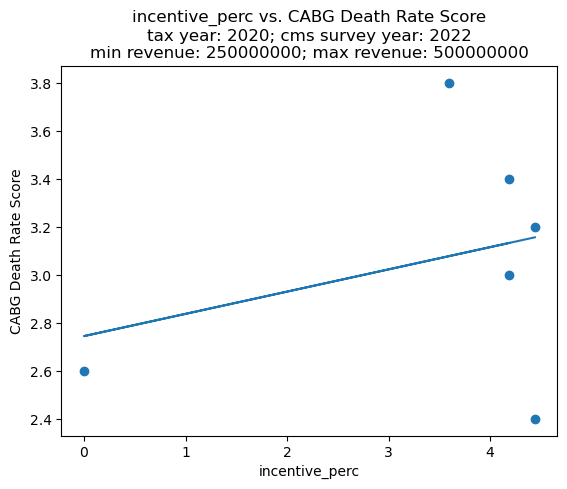

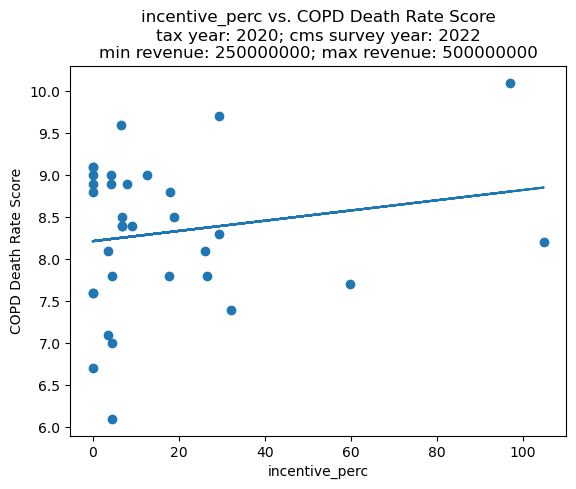

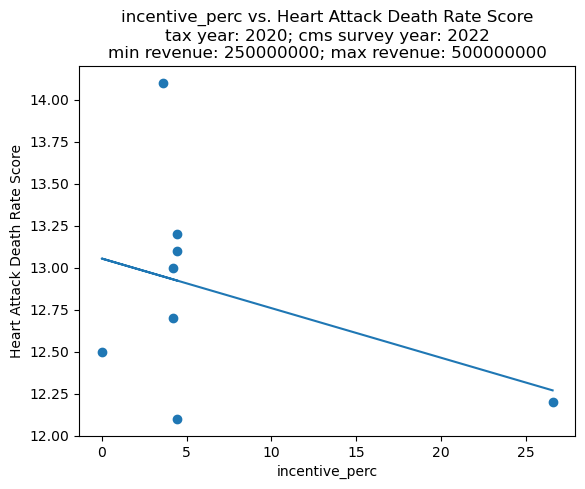

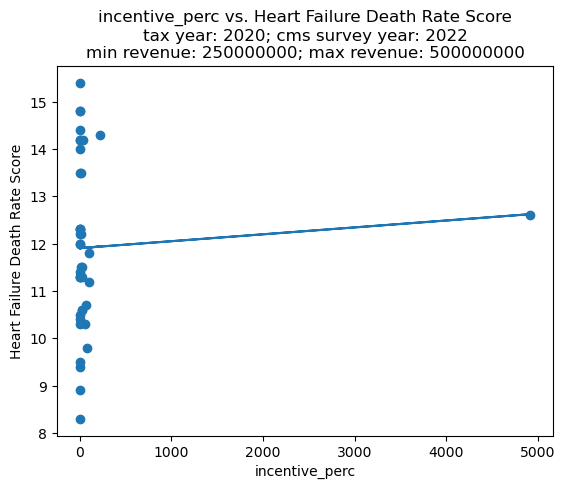

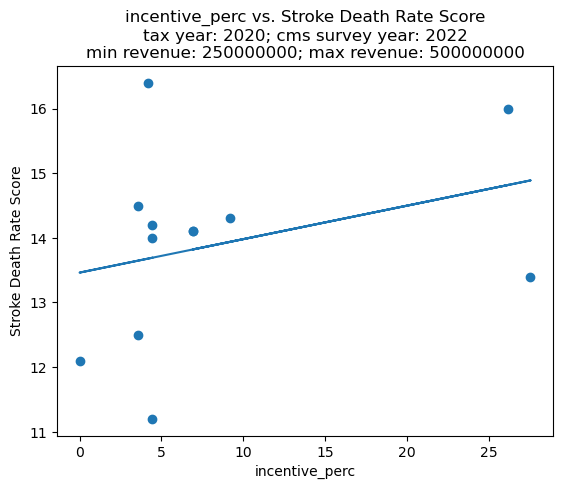

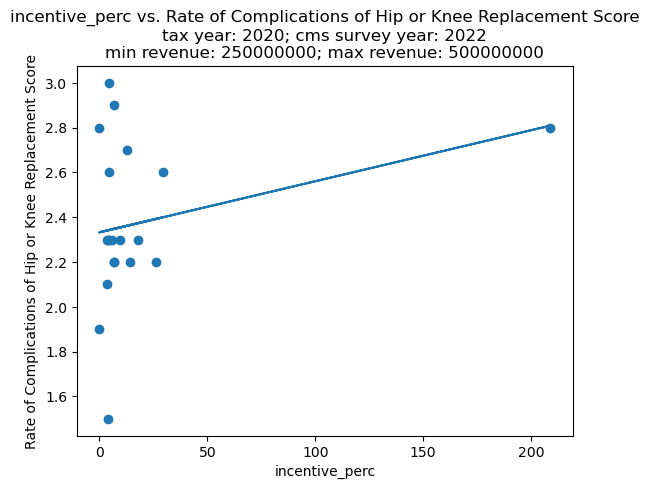

In [190]:
def plot_results(x_col,
                 y_col,
                 merged,
                 year,
                 min_rev,
                 max_rev):

    merged = merged[[x_col, y_col]].dropna()
    x = merged[x_col]
    y = merged[y_col]

    fig_id = f"{x_col}_vs_{y_col}_year={year}_cmsYear={2022}_minRev={min_rev}_maxRev={max_rev}"
    
    m, b, r, p, std_err = stats.linregress(x, y)

    fig = plt.subplots()
    
    plt.scatter(x, y)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{x_col} vs. {y_col}\n' +\
              f'tax year: {year}; cms survey year: 2022\n' +\
              f'min revenue: {min_rev}; max revenue: {max_rev}')
    plt.plot(x, list(map(lambda x: (m * x) + b, x)))
    linreg = f"""
x: {x_col}
y: {y_col}
slope: {m}
intercept: {b}
r: {r}
p: {p}
std err: {std_err}
    """
    print(linreg)
    plt.savefig(f"results/{fig_id}.png")
    with open(f"results/{fig_id}.txt", "w") as f:
        f.write(linreg)

for dep_var in [
    'Overall Linear Mean HCAHPS Hospital Rating',
    'CABG Death Rate Score',
    'COPD Death Rate Score',
    'Heart Attack Death Rate Score',
    'Heart Failure Death Rate Score',
    'Stroke Death Rate Score',
    'Rate of Complications of Hip or Knee Replacement Score'
]:
    plot_results('incentive_perc', dep_var, merged, TAX_YEAR, MIN_HOSPITAL_REV, MAX_HOSPITAL_REV)

# 5. Do a full regression 

In [202]:
import statsmodels.api as sm

df_model = merged[['is_teaching_hospital',
                   'Number of Beds',
                   'incentive_perc',
                   'Overall Linear Mean HCAHPS Hospital Rating']].dropna()
X = df_model[['is_teaching_hospital',
            'Number of Beds',
            'incentive_perc']]
X = sm.add_constant(X)

Y = df_model['Overall Linear Mean HCAHPS Hospital Rating']

model = sm.OLS(Y, X)
results = model.fit()


In [203]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                        
======================================================================================================
Dep. Variable:     Overall Linear Mean HCAHPS Hospital Rating   R-squared:                       0.123
Model:                                                    OLS   Adj. R-squared:                  0.055
Method:                                         Least Squares   F-statistic:                     1.816
Date:                                        Thu, 18 Sep 2025   Prob (F-statistic):              0.160
Time:                                                14:28:25   Log-Likelihood:                -119.45
No. Observations:                                          43   AIC:                             246.9
Df Residuals:                                              39   BIC:                             254.0
Df Model:                                                   3                                         
Covariance Type:                                    nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   89.2020      0.854    104.509      0.000      87.476      90.928
is_teaching_hospital    -3.8557      1.921     -2.007      0.052      -7.741       0.030
Number of Beds           0.0014      0.003      0.419      0.677      -0.006       0.008
incentive_perc           0.0049      0.010      0.467      0.643      -0.016       0.026
==============================================================================
Omnibus:                       33.495   Durbin-Watson:                   2.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.723
Skew:                          -1.984   Prob(JB):                     1.99e-20
Kurtosis:                       8.907   Cond. No.                         742.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [206]:
with open(f"results/ols_year={TAX_YEAR}_cmsYear={2022}_minRev={MIN_HOSPITAL_REV}_maxRev={MAX_HOSPITAL_REV}.txt", "w") as f:
    f.write(results.summary().as_text())